# Step1: Source injection

In [1]:
import lib.butler as btl
import lib.tools as tl
import lib.stamp as stp
import lib.inject as inj
import lib.visual as vis

In [2]:
%matplotlib inline

Begin with ECDFS (center). 

In [3]:
ra_cen = 53.076
dec_cen = -28.110
band = 'i'

Define the grid for injection. It is based on RA/DEC rather than X/Y pixel coordinates. 

Also, the grid is near the (ECDFS) field center, not the image center.

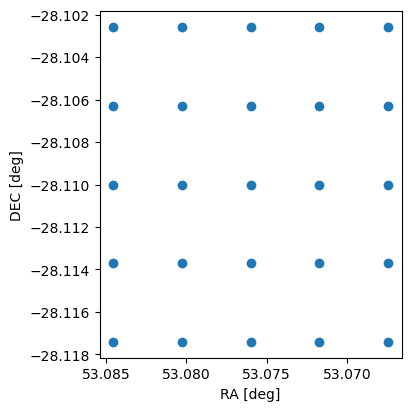

In [4]:
width_arcmin = 1
num_side = 5

RA_arr, DEC_arr = inj.make_grid(ra_cen, dec_cen, width_arcmin, num_side)

## Visit Image Injection

In [5]:
dataset_refs = btl.get_visit_dataset_refs(ra_cen, dec_cen, band)
print(len(dataset_refs))
print(dataset_refs[0])

148
visit_image@{instrument: 'LSSTComCam', detector: 0, visit: 2024110800245, band: 'i', day_obs: 20241108, physical_filter: 'i_06'} [sc=ExposureF] (run=LSSTComCam/runs/DRP/DP1/DM-53601 id=019b1941-8acf-7980-8487-d82d7c24a5af)


Select one visit. 

In [6]:
visit_index = 0 
visit_image = btl.get_visit_image(dataset_refs, visit_index)
visit_rotation_angle = tl.get_visit_rotation_angle(visit_image)
print(visit_rotation_angle, "deg")

102.799378733233 deg


In [7]:
dataId = dataset_refs[visit_index].dataId
tag = "visit_%d"%dataId['visit']

### Choose a stamp (and rotate)

In [8]:
system_index = 1
time_index = 0
stamp_folder = tl.STAMP_FOLDER

Rotate the stamp before injecting into the visit image.

In [9]:
system_tag = "system_%d"%system_index
stamp_tag = "%s_%d"%(system_tag, time_index)
#coadd_stamp_tag = "%s_coadd"%system_tag
wcs_stamp_filename = "%s/%s_wcs.fits"%(stamp_folder, stamp_tag)
stp.make_rotated_stamp(visit_rotation_angle, wcs_stamp_filename)

0

### Inject the (rotated) stamp to a visit image

Inject onto the grid.

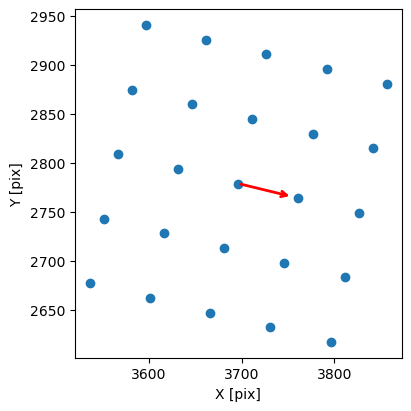

In [10]:
stamp_mag = 20.
stamp_rot_filename = wcs_stamp_filename.replace(".fits", "_rot.fits")
stamp_filename = stamp_rot_filename 

inj_catalog_visit, x_arr, y_arr = inj.make_inj_catalog_visit(
                                        visit_image, 
                                        stamp_mag, 
                                        stamp_filename, 
                                        RA_arr, DEC_arr
                                    )

injected_visit_image, injected_visit_catalog = inj.visit_inject_stamp(visit_image, inj_catalog_visit)

In [11]:
#injected_visit_catalog

In [12]:
tl.save_pickle(tag, visit_image, tl.FIG_FOLDER)
tl.save_pickle("injected_" + tag, injected_visit_image, tl.FIG_FOLDER)

0

### Check the image with cutout

Make a cutout at the central region.

0

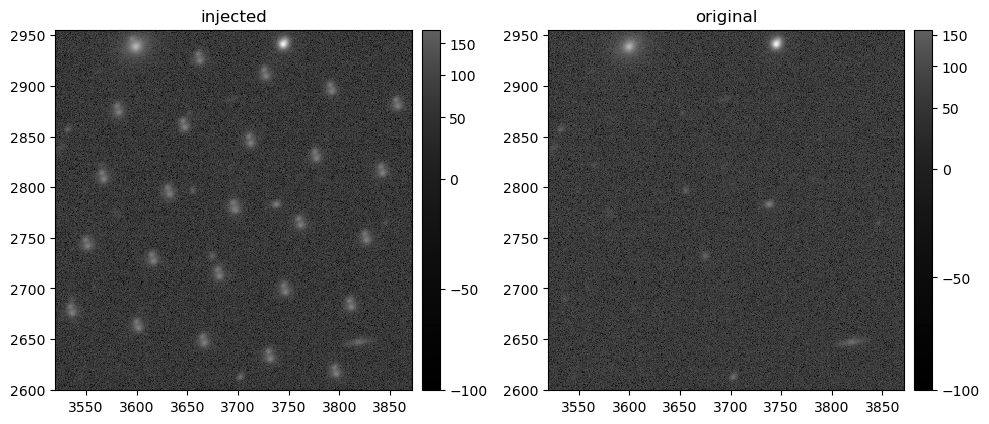

In [13]:
vis.plot_dual(visit_image, injected_visit_image, x_arr, y_arr, image_type="visit")

## Template injection

In [14]:
dataset_refs = btl.get_template_dataset_refs(ra_cen, dec_cen, band)
print(len(dataset_refs))
print(dataset_refs[0])

2
template_coadd@{band: 'i', skymap: 'lsst_cells_v1', tract: 5063, patch: 14} [sc=ExposureF] (run=LSSTComCam/runs/DRP/DP1/DM-51335 id=014f2da9-c3ff-495f-83ef-e1a1ab666231)


Select one template.

In [15]:
template_index = 0 
template_image = btl.get_template_image(dataset_refs, template_index)

In [16]:
dataId = dataset_refs[template_index].dataId
tag = "template_%d_%d"%(dataId['tract'], dataId['patch'])

Follow similar procedure to the visit images, but note coadd patches do not need the rotation.

### Inject the (unrotated) stamp to a template image

Inject onto the grid.

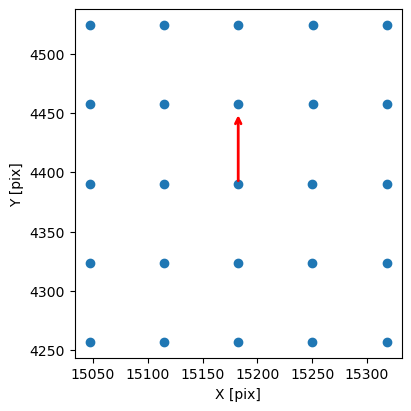

In [17]:
stamp_mag = 20.
stamp_filename = wcs_stamp_filename

inj_catalog_template, x_arr, y_arr = inj.make_inj_catalog_template(
                                        template_image, 
                                        stamp_mag, 
                                        stamp_filename, 
                                        RA_arr, DEC_arr
                                    )

injected_template_image, injected_template_catalog = inj.template_inject_stamp(template_image, inj_catalog_template)

In [18]:
#injected_template_catalog

In [19]:
tl.save_pickle(tag, template_image, tl.FIG_FOLDER)
tl.save_pickle("injected_" + tag, injected_template_image, tl.FIG_FOLDER)

0

### Check the image with cutout

Make a cutout at the central region.

0

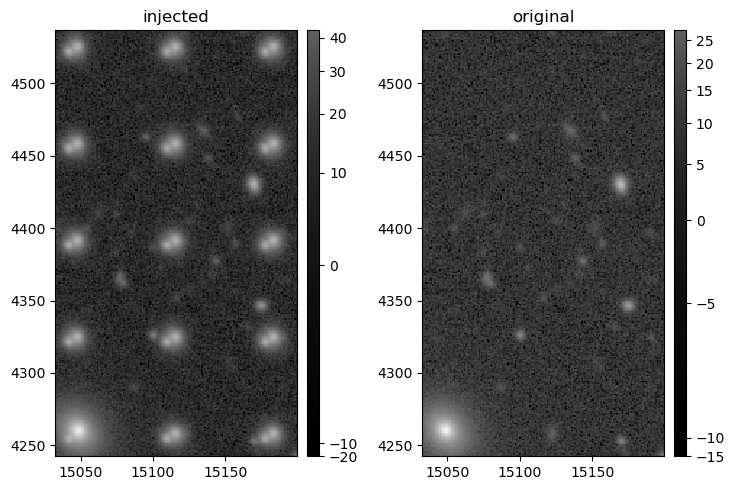

In [20]:
vis.plot_dual(template_image, injected_template_image, x_arr, y_arr, image_type="template")